本文是对PyTorch Tutorials的学习，原文地址https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html,
编辑:weiyang,微信:damo894127201,Time:2019.2.2

这次我们使用char-RNN来生成名字

```Python
> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py German GER
Gerren
Ereng
Rosher

> python sample.py Spanish SPA
Salla
Parer
Allan

> python sample.py Chinese CHI
Chan
Hang
Iun
```

我们手工编写有几个线性层的RNN。与读取名字的每个字符(字母)来预测名字所属的语言类别不同的是，我们输入语言类别并一次输出一个字符。循环预测字符形成语言(这可以用单词或其它更高阶的结构来完成)通常被称为**"语言模型"**。

# Preparing the Data：准备数据

data/names文件夹下有一大堆纯文本文件[Language].txt,文件内容是每行一个name。我们将会将每行放进一个array，然后将Unicode编码转为ASCII，最后输出一个字典{language:[names,...]} 。

In [1]:
from __future__ import unicode_literals,print_function,division
from io import open
import glob  # 使用通配符查找文件目录和文件的模块
import os
import unicodedata # 将文本编码标准化
import string

## 生成模型的字符列表

string.ascii_letters 生成26个字母，包含大小写

string.digits 生成0-9的数字

In [2]:
all_letters = string.ascii_letters + " .,;'-" # 所需要的字符集合
n_letters = len(all_letters) + 1 # puls EOS marker 字符类型个数应该加上结束符EOS

## 定义利用通配符查找文件的函数

glob模块支持 * ? [] 三种通配符

1. \*代表0个或多个字符
2. ?代表一个字符
3. []匹配指定范围内的字符，如[0-9]匹配数字

glob.glob(regx):返回符合条件的文件列表

glob.iglob(regx):返回符合条件的文件迭代器，适合于大量文件的目录

In [3]:
def findFiles(path):
    return glob.glob(path)

## 将Unicode字符串转为纯ASCII字符串:字符串标准化

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s) # 把Unicode字符转为Normalization Form D(NFD)格式的字符串
        if unicodedata.category(c) != 'Mn' # 该字符c在unicode分类的类型，不是 Mark, Nonspacing
        and c in all_letters
    ) # join()里其实是个列表推导

## 读取文件并将其分割成一行一行

In [5]:
def readLines(filename):
    lines = open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

## 构建{语言类别:names}字典，其中names是个name列表

In [6]:
category_lines = {}
all_categories = []
# 遍历data/names文件下的文件
for filename in findFiles('data/names/*.txt'):
    # os.path.basename(filename)返回filename最后位置处的文件名
    # os.path.splitext（）分离文件名与扩展名
    category = os.path.splitext(os.path.basename(filename))[0]# 获取语言类别
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories) # 语言类别个数
if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')
    
print('# categories:',n_categories,all_categories)
print()
print(unicodeToAscii("O'Néàl")) # 查看字符串标准化是否运行异常

# categories: 18 ['English', 'Korean', 'Greek', 'Czech', 'Polish', 'Chinese', 'Japanese', 'Vietnamese', 'Scottish', 'French', 'Russian', 'Portuguese', 'Dutch', 'German', 'Arabic', 'Spanish', 'Irish', 'Italian']

O'Neal


# Creating the Network:搭建网络

该网络扩展了[Classifying Names with a Character-Level RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)教程的RNN，并为类别Tensor提供了额外的参数，该参数与其他类型连接在一起。 类别张量是一个单热矢量，就像字母输入一样。

我们将输出(output)解释为下一个字母(next letter)的概率。 采样(sample)时，最可能的(概率最大)输出字母用作下一个输入字母。

在hidden层和output层之后，我添加了第二个线性层$o2o$以使得网络更健壮。网络里也增加了dropout层，它会随机将输入input的一部分以0.1的概率置为0，这经常用来模糊输入input以防止过拟合。在这儿，我们在网络的尾端使用dropout，故意增加input的混乱以增加采样sampling的多样性，好使得输出字母的能更多样。

![网络结构](./image/char_RNN_generating_names.png)

下面是一个完整的RNN结构

In [7]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size,hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size,output_size)
        self.o2o = nn.Linear(hidden_size + output_size,output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,category,input,hidden):
        input_combined = torch.cat((category,input,hidden),1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden,output),1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output,hidden # RNN的输出和隐状态
    
    def initHidden(self): # RNN隐藏层初始状态
        return torch.zeros(1,self.hidden_size)

# Training：训练

## Preparing for Training

用辅助函数来随机获取(category,name)对

In [8]:
import random

# Random item from a list
def randomChoice(lst):
    return lst[random.randint(0,len(lst) -1)]

# get a random category and random name from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    name = randomChoice(category_lines[category])
    return category,name

对于每个时间步timestep(也就是训练Word的每个字母),RNN的输入是(category,current_letter,hidden_state)，输出是(next_letter,next_hidden_state)。因此对于训练集，我们需要准备语言类别category，输入name的字母集合,输出目标name的字母集合。

由于我们是通过当前时间步的字母来预测下一个时间步的字母的，因此**字母对**letter paris是当前输入name的连续字母组，如输入$"ABCD<EOS>"$，将会转变为$('A','B'),('B','C'),('C','D'),('D','EOS')。

![RNN_input](./image/RNN_input.png)

category Tensor是一个(1 x n_categories)维的one-hot张量。在训练时，每个时间步timestep我们都要灌进网络里--这是一个可选项，它是初始隐状态或其他策略的一部分。

category的one-hot向量 

In [9]:
def categoryTensor(category):
    li = all_categories.index(category) # 获取类别索引位置编号
    tensor = torch.zeros(1,n_categories)
    tensor[0][li] = 1
    return tensor

RNN的输入： input name 中从第一个字母到最后一个字母的one-hot matrix，不包括<EOS>

In [10]:
def inputTensor(line):
    tensor = torch.zeros(len(line),1,n_letters) # len(name) x 1 x 字符的个数(包括EOS)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

RNN的目标输出： input name 中从第二个字母到EOS结束的one-hot matrix,第一个字母的目标输出是第二个字母，第二个是第三个,...,最后一个字母目标输出是EOS

In [11]:
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1,len(line))]
    letter_indexes.append(n_letters - 1) # 再加上EOS
    return torch.LongTensor(letter_indexes)

我们再写一个辅助函数，用来对输入数据进行随机抽取，然后将抽取的(category,name)对转为RNN的输入tensor（category,input,target）

In [12]:
# make (category,input,target) tensors from a random (category,name)对
def randomTrainingExample():
    category,line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor,input_line_tensor,target_line_tensor

## Training the Network

用RNN分类时，只有最后时间步的输出有用，而在这里，每一时间步都要做预测，因此每一时间步都要计算损失。

自动微分模块autograd允许你轻松计算每一时间步的损失和，最后再调用backward反向传播更新权重

In [13]:
# 由于已经用softmax做过对数了，因此用NLLLoss
# 损失函数NLLLoss() 的 输入 是一个对数概率向量和一个目标标签. 
# 它不会为我们计算对数概率，适合最后一层是log_softmax()的网络
loss_func = nn.NLLLoss() # 定义损失函数
learning_rate = 0.0005

def train(category_tensor,input_line_tensor,target_line_tensor):
    target_line_tensor.unsqueeze_(-1) # 在最后一个维度上增加一个维度，以便在维度上与RNN的输出output相一致
    hidden = rnn.initHidden() # 初始化最开始的隐状态
    
    rnn.zero_grad()
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output,hidden = rnn(category_tensor,input_line_tensor[i],hidden)
        ls = loss_func(output,target_line_tensor[i]) # 计算损失
        loss += ls
    
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate,p.grad.data) # 挨个更新参数
    
    return output,loss.item() / input_line_tensor.size(0)

计算网络训练时长

In [14]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds'% (m,s)

训练时，会输出当前时间和相应的损失，并保留相应的损失便于后期可视化损失

In [15]:
rnn = RNN(n_letters,128,n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # reset every plot_every iters

start = time.time()

for it in range(1,n_iters + 1):
    output,loss = train(*randomTrainingExample())
    total_loss += loss
    
    if it % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), it, it / n_iters * 100, loss))
    
    if it % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 20s (5000 5%) 2.7672
0m 33s (10000 10%) 2.7377
0m 48s (15000 15%) 2.5650
1m 5s (20000 20%) 3.0229
1m 19s (25000 25%) 1.2880
1m 33s (30000 30%) 2.5434
1m 47s (35000 35%) 2.1538
2m 5s (40000 40%) 3.3355
2m 22s (45000 45%) 2.2169
2m 37s (50000 50%) 2.6645
2m 51s (55000 55%) 2.3424
3m 10s (60000 60%) 3.1401
3m 24s (65000 65%) 2.4152
3m 36s (70000 70%) 2.1437
3m 52s (75000 75%) 1.1670
4m 7s (80000 80%) 1.8012
4m 21s (85000 85%) 2.1307
4m 36s (90000 90%) 2.0935
4m 49s (95000 95%) 2.1107
5m 2s (100000 100%) 1.9913


## Plotting the Losses

展示训练过程中的损失变化

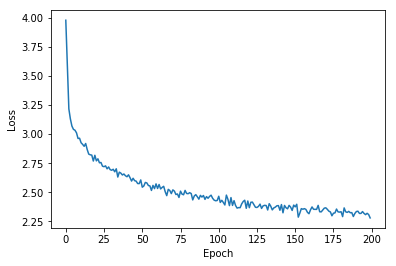

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Sampling the Network:预测

抽样就是，我们给定一个字母letter，然后希望RNN能够出定下一个字母(next letter),然后将这个字母输入RNN，重复这个过程，直至遇到\<EOS>。

1. 为input category,starting letter创建tensors，并将初始的hidden state置为0
2. 用starting letter构建output_name字符串
3. 重复，直至output最大的长度:
    1. 将当前字母letter灌进RNN
    2. 获取RNN概率最大的输出output作为next letter 和 next hidden state
    3. 如果当前字母为EOS，则停止
    4. 如果是其他字母，就将其加入output_name中，然后继续循环
4. 返回output_name

Notes:另一种策略不是必须给它一个起始字母，而是在训练中包括“字符串开始”标记，并让网络选择自己的起始字母。

In [17]:
max_length = 20

# sampling from a category and starting letter 
def sample(category,start_letter='A'):
    with torch.no_grad(): 
        category_tensor = categoryTensor(category)
        input_ = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output,hidden = rnn(category_tensor,input_[0],hidden)
            topv,topi = output.topk(1) # 返回最大的K个元素
            topi = topi[0][0] # 获取最大值对应的索引
            if topi == n_letters - 1: # 如果是EOS
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input_ = inputTensor(letter)
            
        return output_name
    
# 获取含有多个起始字母的结果
def samples(category,start_letters='ABC'):
    for start_letter in start_letters:
        print('start letter : %s\n'%start_letter,sample(category,start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

start letter : R
 Rovekov
start letter : U
 Uarinov
start letter : S
 Shanovek
start letter : G
 Geren
start letter : E
 Eren
start letter : R
 Roun
start letter : S
 Sanera
start letter : P
 Pares
start letter : A
 Allan
start letter : C
 Chan
start letter : H
 Hai
start letter : I
 Iui
